In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


1.	Find historical bitcoin prices from 2019 onwards.

2.	Import the data.

In [2]:
btc_data = pd.read_csv("COINBASE_BTCUSD_1D.csv")

In [3]:
print(btc_data.head)

<bound method NDFrame.head of             time      open      high       low     close        Volume  \
0     2016-09-29    604.96    606.89    603.56    605.99   4071.000000   
1     2016-09-30    605.99    608.99    605.00    608.99   4589.000000   
2     2016-10-01    608.99    617.19    608.98    615.65   3440.000000   
3     2016-10-02    615.65    615.90    608.66    612.40   2859.000000   
4     2016-10-03    612.42    615.24    610.70    612.99   4397.000000   
...          ...       ...       ...       ...       ...           ...   
3351  2025-12-02  86282.35  92342.00  86181.38  91308.05  13070.695787   
3352  2025-12-03  91308.05  94181.41  91024.47  93453.84   9743.088352   
3353  2025-12-04  93452.02  94087.05  90904.73  92093.54   6201.789786   
3354  2025-12-05  92093.70  92716.42  88099.05  89345.29   8310.938978   
3355  2025-12-06  89345.29  89829.99  89047.51  89699.18    822.699315   

            RSI  Upper Bollinger Band  Lower Bollinger Band  Regular Bullish  \
0

2. changing the Coinbase 'time' column to 'Date'. and keeping only the 'high' column


In [4]:
# Rename 'time' column to 'Date' first
btc_data.rename(columns={'time': 'Date'}, inplace=True)

# Convert 'Date' to datetime and set as index
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.set_index('Date', inplace=True)

# Keep only the 'high' column
btc_data = btc_data[['high']]

print(btc_data.head())

              high
Date              
2016-09-29  606.89
2016-09-30  608.99
2016-10-01  617.19
2016-10-02  615.90
2016-10-03  615.24


In [5]:
# Check for NaNs in the original dataset
if btc_data.isnull().values.any():
    print("NaN values found in the original dataset. They will be dropped.")
    btc_data.dropna(inplace=True)  # Drop rows with NaN values
print(btc_data.head())

              high
Date              
2016-09-29  606.89
2016-09-30  608.99
2016-10-01  617.19
2016-10-02  615.90
2016-10-03  615.24


3.1	Split the data into train and test. Train should be 2019 – 2022. Test should be 2023 onward.

In [6]:
train_data = btc_data['2019-01-01':'2022-12-31']
test_data = btc_data['2023-01-01':]

3.2	Visualize the time series.

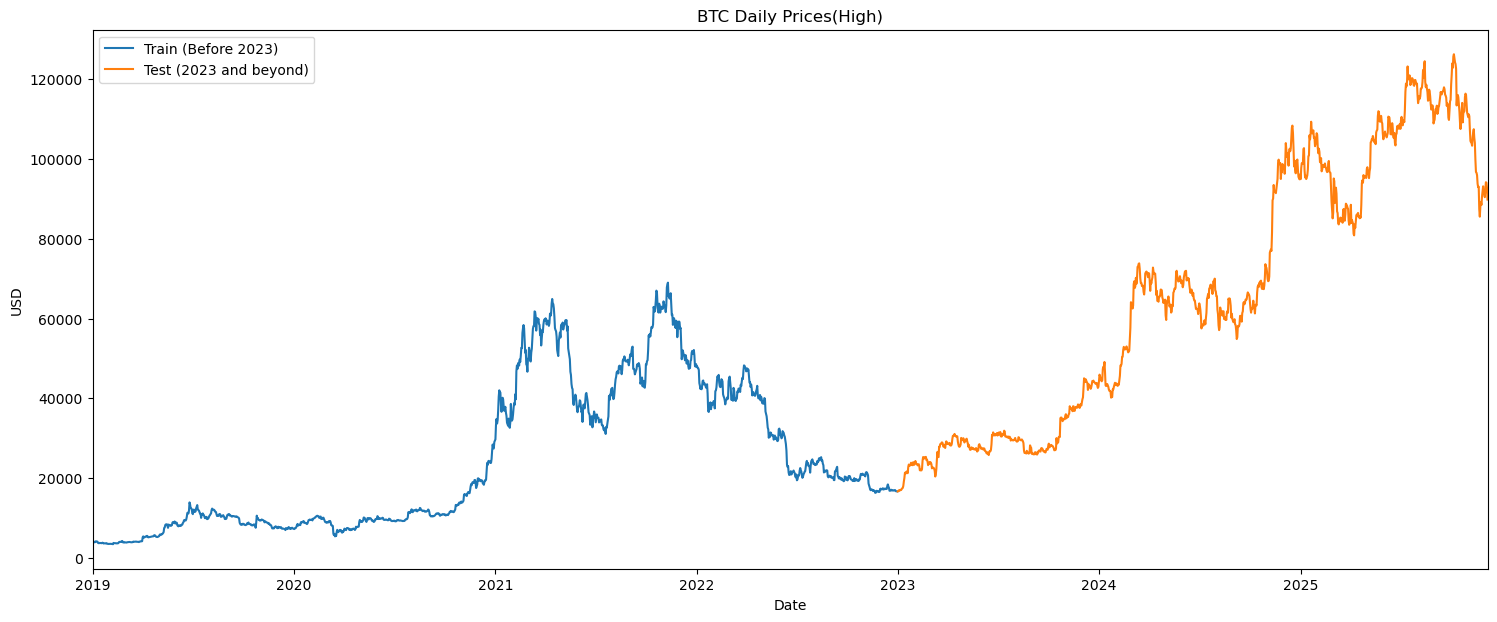

In [7]:
plt.figure(figsize=(18, 7))
plt.plot(train_data, label='Train (Before 2023)')
plt.plot(test_data, label='Test (2023 and beyond)')
plt.title('BTC Daily Prices(High)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.xlim([pd.Timestamp('2019-01-01'), test_data.index.max()])
plt.show()

4.	Scale the data

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

In [9]:
if np.isnan(scaled_train_data).any():
    print("NaN values found in scaled train data.")
if np.isnan(scaled_test_data).any():
    print("NaN values found in scaled test data.")

5.  Create sliding windows (30-day lookback → next-day prediction).

In [10]:
def create_dataset(data, sequence_length=30):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x_seq = data[i:(i + sequence_length)]
        y_seq = data[i + sequence_length]
        if not np.isnan(x_seq).any() and not np.isnan(y_seq):  # Check for NaNs in both input and output
            x.append(x_seq)
            y.append(y_seq)
    return np.array(x), np.array(y)

X_train, y_train = create_dataset(scaled_train_data)
X_test, y_test = create_dataset(scaled_test_data)



B.	Build an LSTM neural network.<br>
•	Define an LSTM network in Keras with:<br>
    o	One or more LSTM layers<br>
    o	Optional Dropout layers<br>
    o	Dense output layer for regression<br>


In [11]:

sequence_length = 30

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


•	Compile using Adam optimizer and MSE/MAE loss. <br>
•	Train and plot the loss over epochs.


Epoch 1/20

45/45 [==============================] - 3s 7ms/step - loss: 0.0143
Epoch 2/20
45/45 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 3/20
45/45 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 4/20
45/45 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 5/20
45/45 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 6/20
45/45 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 7/20
45/45 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 8/20
45/45 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 9/20
45/45 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 10/20
45/45 [==============================] - 0s 7ms/step - loss: 9.7057e-04
Epoch 11/20
45/45 [==============================] - 0s 7ms/step - loss: 9.3069e-04
Epoch 12/20
45/45 [==============================] - 0s 7ms/step - loss: 9.6136e-04
Epoch 13/20
45/45 [=================

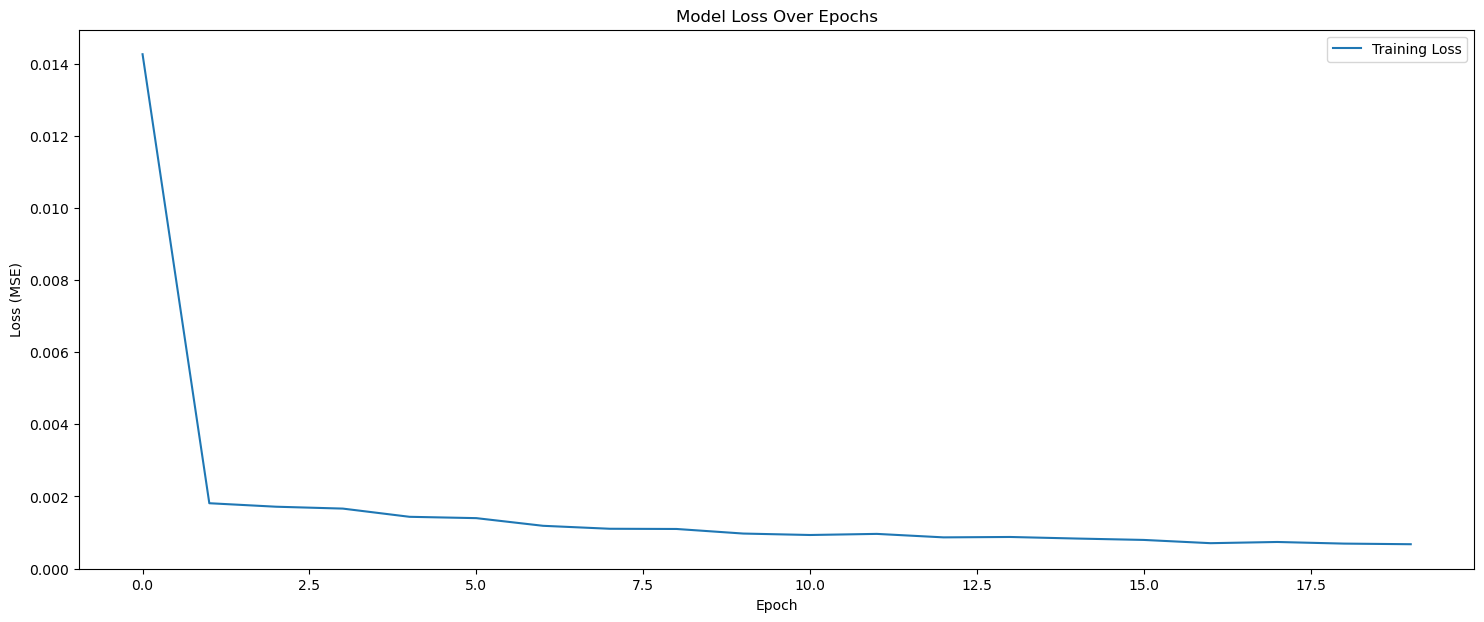

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
plt.figure(figsize=(18, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

C Evaluate and Visualiz
•	Predict test prices and plot actual vs predicted.

•	Predict test prices and plot actual vs predicted.

In [13]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

33/33 [==============================] - 1s 2ms/step


Visualize the actual and predicted prices.

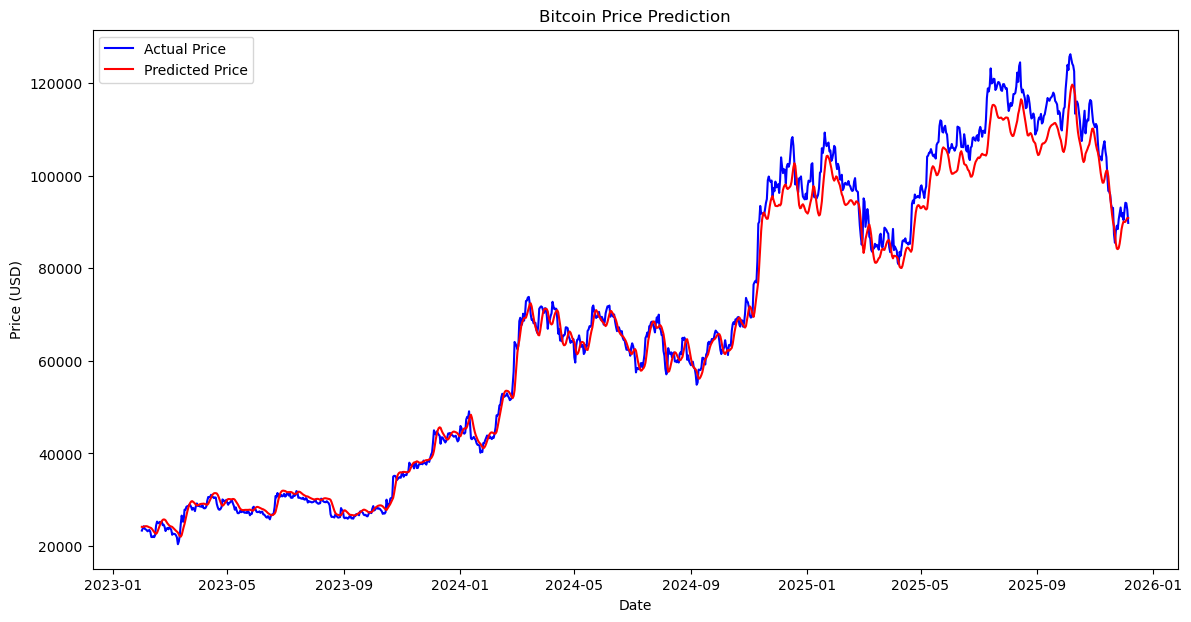

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(test_data.index[sequence_length:], test_data.values[sequence_length:], label='Actual Price', color='blue')
plt.plot(test_data.index[sequence_length:], predicted_prices, label='Predicted Price', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

An Extra step to predict the next 30 days of price from December 6 using the 30 days prior to present. 

1/1 [==============================] - 0s 16ms/step


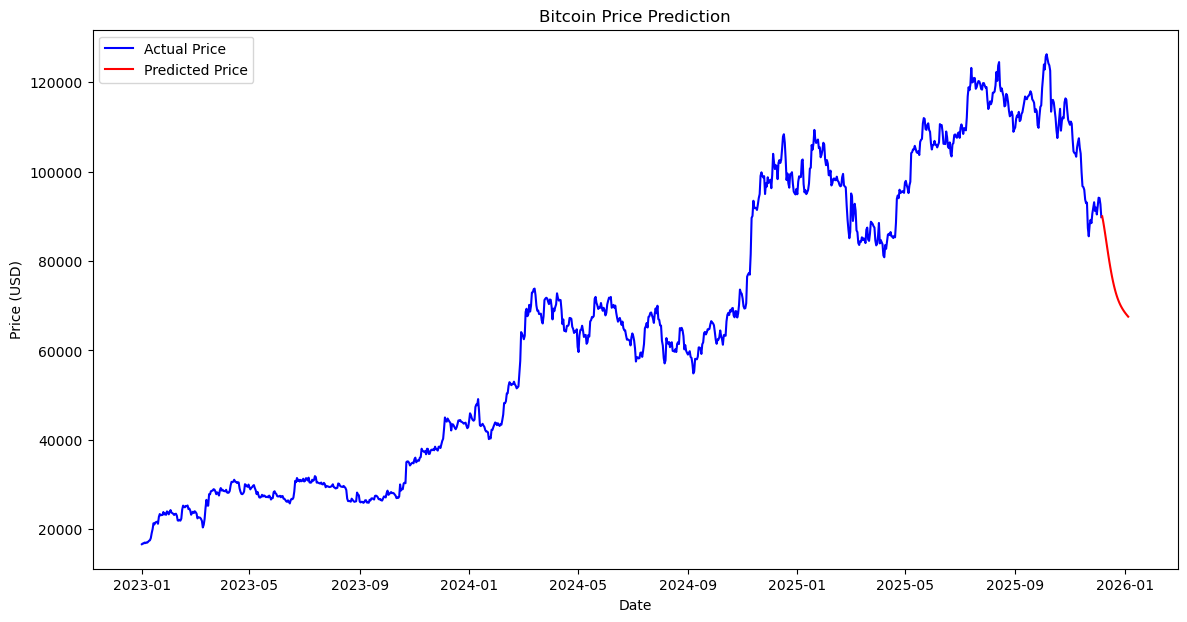

In [17]:

def predict_next_30_days(initial_sequence, model, scaler, days=30):
    current_sequence = initial_sequence.copy()  # Ensure the sequence is not modified outside the function
    predicted_prices = []

    for _ in range(days):
        # Reshape the input to fit the model expected input shape
        current_input = current_sequence.reshape(1, 30, 1)  # Shape (1, 30, 1)

        # Predict the next price
        scaled_prediction = model.predict(current_input)

        # Check for NaN values in the prediction
        if np.isnan(scaled_prediction).any():
            print("NaN values detected in prediction output.")
            break

        # Inverse transform the scaled prediction
        predicted_price = scaler.inverse_transform(scaled_prediction)[0][0]
        predicted_prices.append(predicted_price)

        # Update the sequence for the next prediction
        current_sequence = np.append(current_sequence[1:], scaled_prediction)  # Use the latest prediction

    return predicted_prices

# Assuming 'scaled_test_data' is already defined and contains the scaled test data
last_sequence = scaled_test_data[-30:]  # Last 30 days from the scaled test data
predicted_prices_30_days = predict_next_30_days(last_sequence, model, scaler)

# Visualizing the predicted prices
if predicted_prices_30_days:
    # Define the starting point for the predictions
    last_date = test_data.index[-1]  # Last date of the test data
    prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(predicted_prices_30_days), freq='D')

    # Create a new figure for plotting
    plt.figure(figsize=(14, 7))

    # Plot actual prices from test data
    plt.plot(test_data.index, test_data['high'], label='Actual Price', color='blue')

    # Plot predicted prices
    plt.plot(prediction_dates, predicted_prices_30_days, label='Predicted Price', color='red')

    # Adding titles and labels
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()

    # Show the plot
    plt.show()
else:
    print("No predictions to display.")

Compute RMSE and discuss overfitting.

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Compute RMSE between actual and predicted prices
actual_prices = test_data.values[sequence_length:]
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 3602.18


The loss curve suggested that the traning went smooth and there is no sign of overfitting. The RMSE suggests that the model works moderately well that the difference in actual price is within 2644 dollars. 

D. Comparative Insight. <br>
•	Compare this deep-learning approach to the tabular churn models: <br>
    o	Differences in data preparation.<br>
    o	Suitability of architectures.<br>
    o	Model evaluation metrics (AUC vs RMSE).


Comparative Insight: LSTM Time-Series vs. Tabular Churn Models
1. Data Preparation Differences

Tabular churn models treat each input as an independent row. Preprocessing focuses on imputing missing values, scaling numerical variables, one-hot encoding categorical features, and performing a random (often times 80/20) split. No ordering or temporal structure is required.
The LSTM model requires sequential structure. Data must be scaled with MinMaxScaler and reshaped into fixed-length sliding windows (e.g., 30-day sequences in our case). Because time matters, the split must be chronological.

2. Suitability of Architectures

Churn models (Logistic Regression, Random Forest, Gradient Boosting) learn relationships among static features and are effective when the target depends on feature snapshots. They are interpretable and do not model time dependencies.
LSTM networks are specifically designed for sequence data. Their memory gates allow them to capture temporal patterns and long-term dependencies, making them more suitable for time-series forecasting tasks.

3. Evaluation Metrics: AUC vs. RMSE

AUC is used for churn because the task is classification. AUC measures how well the model ranks high-risk vs. low-risk customers, which is central to churn management.
RMSE is used for the LSTM because the task is regression. RMSE directly measures the average prediction error in the same units as the target (e.g., USD), which aligns with forecasting accuracy.

In summary, churn models operate on independent tabular features and emphasize ranking performance (AUC), while the LSTM model operates on sequential data and emphasizes numeric accuracy (RMSE).